# Exfoliation Bandgap Binning

In this notebook, we train an XGBoost regressor to predict exfoliation energies. We include whether the bandgap is low or high as a descriptor.

In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Dataset

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

target_column = ['exfoliation_energy_per_atom (eV/atom)']

# Filter out by several masks

- `element_mask` - throw away systems containing noble gases, f-blocks, or any synthetic elements
- `decomposition_mask` - keep systems with a decomposition energy < 0.5 eV/atom
- `exfol_mask` - keep systems with an exfoliation energy > 0 eV/atom
- `hull_mask` - keep systems whose parent structures e_above_hull reported by Materials Project is <= 0.05

And finally, do a train/test split

In [4]:
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block

element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

exfoliation_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

reasonable = data[element_mask & decomposition_mask & exfoliation_mask]

# Descriptor selection

XenonPy and Matminer

In [5]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors

In [6]:
borderline = np.percentile(reasonable['bandgap (eV)'], 50)
print(f"50th percentile is at a bandgap of {borderline} eV")
bandgap_low_mask = reasonable['bandgap (eV)'] <= borderline
bandgap_high_mask = ~bandgap_low_mask

50th percentile is at a bandgap of 0.7799999999999999 eV


In [7]:
reasonable['low_bandgap'] = bandgap_low_mask.astype(int)

<ipython-input-7-e6d96d444339>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reasonable['low_bandgap'] = bandgap_low_mask.astype(int)


In [8]:
train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [9]:
train_x_regression = np.nan_to_num(train[xenonpy_matminer_descriptors + ['low_bandgap']].to_numpy())
train_y_regression = np.nan_to_num(train[target_column].to_numpy())

test_x_regression = np.nan_to_num(test[xenonpy_matminer_descriptors + ['low_bandgap']].to_numpy())
test_y_regression = np.nan_to_num(test[target_column].to_numpy())

# XGBoost Hyperparameter Tuning

Tune an XGBoost regressor for the exfoliation energy using Optuna.

In [10]:
current_regression = None
best_regression = None
def keep_best_regression(study, trial):
    global best_regression
    if study.best_trial == trial:
        best_regression = current_regression

objective_train_x_regression, objective_validation_x_regression, objective_train_y_regression, objective_validation_y_regression = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_regression), train_y_regression, test_size=0.1, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_regression

    current_regression = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 100),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 10),
            reg_alpha = trial.suggest_float('alpha', 0, 5),
            reg_lambda = trial.suggest_float('lambda', 0, 5),
            n_estimators=200,
            objective='reg:squarederror',
            random_state=RANDOM_SEED),),
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_regression.fit(X=objective_train_x_regression, y=objective_train_y_regression,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_regression, objective_validation_y_regression]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 10,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_regression,
        y_pred=abs(current_regression.predict(objective_validation_x_regression)),
    )

    return np.sqrt(score)

regression_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize'
)

regression_study.optimize(func=objective, n_trials=256, callbacks=[keep_best_regression])

[I 2021-08-31 12:25:43,482] A new study created in memory with name: no-name-08823e3e-e093-45e7-91f4-ea3b0d12a8f1
[I 2021-08-31 12:25:44,102] Trial 0 finished with value: 0.0872239132199962 and parameters: {'max_depth': 20, 'min_child_weight': 6.221087710398319, 'alpha': 2.1886386950355723, 'lambda': 3.926792918568846}. Best is trial 0 with value: 0.0872239132199962.
[I 2021-08-31 12:25:45,296] Trial 1 finished with value: 0.069500026353131 and parameters: {'max_depth': 78, 'min_child_weight': 2.7259260528264164, 'alpha': 1.3823212757154835, 'lambda': 4.009360887675096}. Best is trial 1 with value: 0.069500026353131.
[I 2021-08-31 12:25:46,131] Trial 2 finished with value: 0.07011066660166689 and parameters: {'max_depth': 96, 'min_child_weight': 8.759326347420947, 'alpha': 1.7890863497893332, 'lambda': 2.5049756276172936}. Best is trial 1 with value: 0.069500026353131.
[I 2021-08-31 12:25:47,214] Trial 3 finished with value: 0.06585347160719739 and parameters: {'max_depth': 69, 'min_ch

# Save summary statistics

- A parity plot for the model and the entire data range
- A bar chart for some of the variable importances
- Model performance statistics are also printed


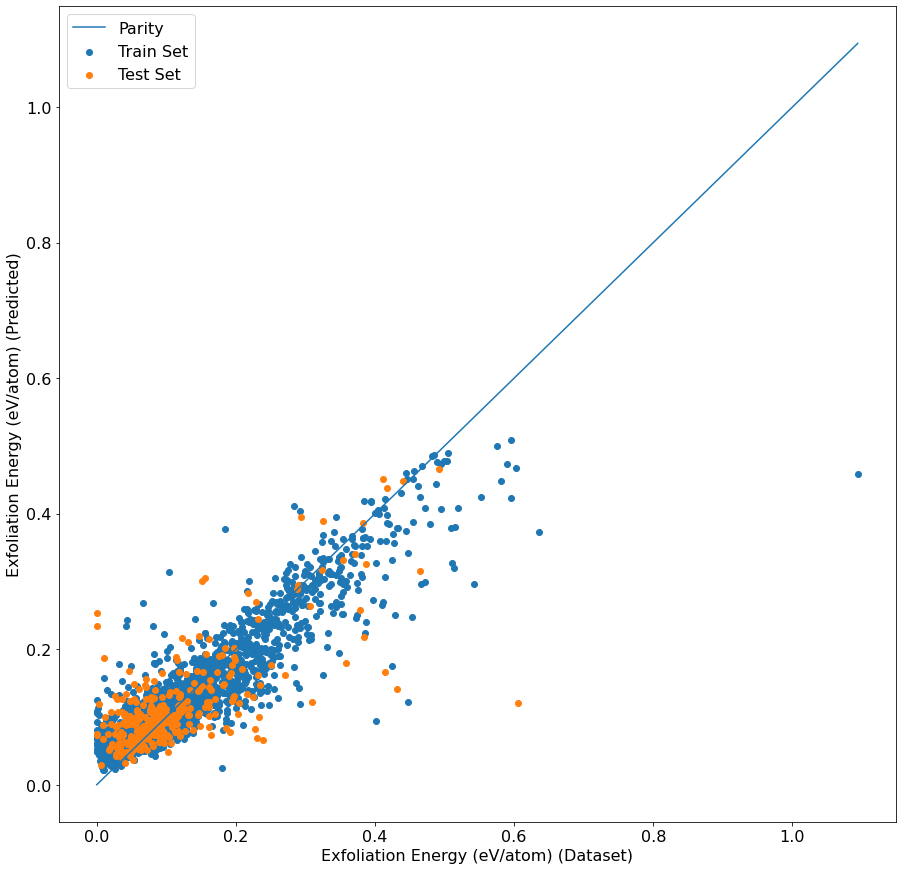

In [11]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression,
                                                test_x_regression,
                                                train_y_regression,
                                                test_y_regression,
                                                best_regression,
                                                "Exfoliation Energy (eV/atom)",
                                                "exfoliation_parity.jpeg")

In [12]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_regression.predict(test_x_regression)
for key, fun in metrics.items():
    value = fun(y_true=test_y_regression, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 0.485
MAE 0.04
MSE 0.004
RMSE 0.063
MAPE 4.783
R2 0.512


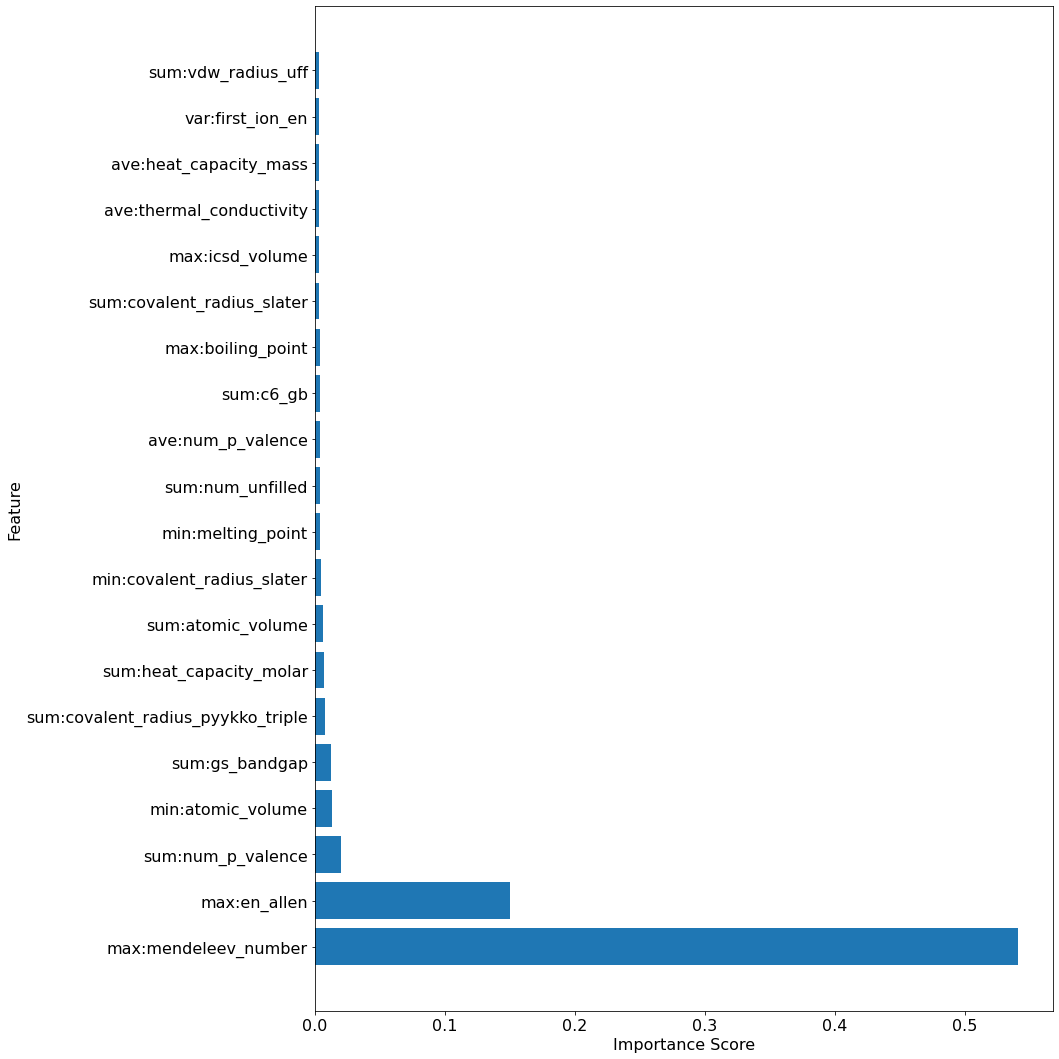

In [13]:
n_importances = 20
importances = list(zip(best_regression[1].feature_importances_, xenonpy_matminer_descriptors + ['low_bandgap']))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("exfoliation_importance.jpeg")